In [1]:
import matplotlib.pyplot as plt
import numpy as np
from nice import *
from utils import *
import tensorflow as tf
import tensorflow_probability as tfp
tfk = tf.keras
tfkl = tfk.layers
tfkc = tfk.callbacks
tfd = tfp.distributions
tfb = tfp.bijectors
K = tfk.backend
print(tf.__version__)
!python --version

2.3.1
Python 3.7.6


In [2]:
inp_dim = 2
n_sample = 1000

n_layer = 3
n_hid = 128
n_batch = 128
n_epoch = 1000
n_display = 100

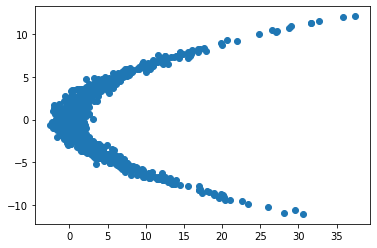

In [3]:
x2 = np.random.normal(0, 4, n_sample)
x1 = np.random.normal(0.25 * x2**2, [1]*n_sample)
X = np.stack([x1, x2], axis=1).astype('float32')
plt.scatter(X[:,0], X[:,1]);

In [4]:
def gen():
    for _ in range(n_sample):
        x2 = np.random.normal(0, 4)
        x1 = np.random.normal(0.25 * x2**2, 1)
        X = np.stack([x1, x2], axis=0).astype('float32')
        yield (X,X)
        
dataset = tf.data.Dataset.from_generator(gen, (tf.float32, tf.float32), output_shapes=(inp_dim, inp_dim))        
dataset = dataset.repeat().shuffle(n_sample).batch(n_batch, drop_remainder=True)
# it = iter(dataset)
# next(it)

In [5]:
class NVPCouplingLayer(tfkl.Layer):
    def __init__(self, inp_dim, n_layer, n_hid, name):
        super(NVPCouplingLayer, self).__init__(name=name)
        self.inp_dim = inp_dim
        self.n_layer = n_layer
        self.n_hid = n_hid
        self.s = FCNN(inp_dim)
        self.t = FCNN(inp_dim)
        self.permute = tfb.Permute(permutation=list(reversed(range(self.inp_dim))), 
                                   name='Permute') # reversed permute

    def call(self, x):
        # Forward mapping: from data to latent
        # Split
        x = tf.reshape(x, [-1, self.inp_dim // 2, 2])
        x1, x2 = x[:, :, 0], x[:, :, 1]
        y2 = x2 * tf.math.exp(self.s(x1)) + self.t(x1)
        y = tf.concat([x1, y2], axis=-1)
        y = self.permute(y)
        return y

    def inverse(self, y):
        # Inverse mapping: from latent to data
        y = self.permute(y)
        y = tf.reshape(y, [-1, self.inp_dim // 2, 2])
        y1, y2 = y[:, :, 0], y[:, :, 1]
        x2 = (y2 - self.t(y1)) * tf.math.exp(-self.s(y1))
        x = tf.concat([y1, x2], axis=-1)
        return x

    
class RealNVP(tfk.Model):
    def __init__(self, inp_dim, n_layer, n_hid, **kwargs):
        super(RealNVP, self).__init__(**kwargs)
        self.inp_dim = inp_dim
        self.n_layer = n_layer
        self.n_hid = n_hid
        self.AffineLayers = []
        for i in range(n_layer):
            layer = NVPCouplingLayer(inp_dim, n_layer, n_hid, name=f'Layer{i}')
            self.AffineLayers.append(layer)
#         self.scale = ScalingLayer(inp_dim)
#         self.AffineLayers.append(self.scale)
        
    def call(self, x):
        '''Forward mapping: from data to latent'''
        for i in range(self.n_layer):
            x = self.AffineLayers[i](x)
#         x = self.scale(x)
        return x
    
    def inverse(self, x):
        '''Inverse mapping: from latent to data'''
#         x = self.scale.inverse(x)
        for i in reversed(range(self.n_layer)):
            x = self.AffineLayers[i].inverse(x)
        return x
    

In [6]:
model = RealNVP(inp_dim, n_layer, n_hid, name='RealNVP')
model.build(input_shape=(inp_dim,))
model.summary()

Model: "RealNVP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer0 (NVPCouplingLayer)    multiple                  1053700   
_________________________________________________________________
Layer1 (NVPCouplingLayer)    multiple                  1053700   
_________________________________________________________________
Layer2 (NVPCouplingLayer)    multiple                  1053700   
Total params: 3,161,100
Trainable params: 3,161,094
Non-trainable params: 6
_________________________________________________________________


In [7]:
def loss_fun(y_true, y_pred):
    # negative log likelihood
    return tf.math.reduce_sum(0.5 * y_pred **2, axis=1)

model.compile(loss=loss_fun, optimizer='adam')

In [10]:
%%time
logger = NBatchLogger(n_display, n_epoch)
hist = model.fit(dataset,
                 epochs=n_epoch,
                 steps_per_epoch=1,
                 callbacks=[logger],
                 verbose=0)

=== Started at 2020-11-18 20h:42m:43s ===
 2020-11-18 20h:42m:44s | Epoch: 1/1000 | loss=1524.359619
 2020-11-18 20h:42m:48s | Epoch: 100/1000 | loss=0.000147
 2020-11-18 20h:42m:52s | Epoch: 200/1000 | loss=0.000011
 2020-11-18 20h:42m:56s | Epoch: 300/1000 | loss=0.000003
 2020-11-18 20h:42m:59s | Epoch: 400/1000 | loss=0.000001
 2020-11-18 20h:43m:03s | Epoch: 500/1000 | loss=0.000001
 2020-11-18 20h:43m:07s | Epoch: 600/1000 | loss=0.000001
 2020-11-18 20h:43m:11s | Epoch: 700/1000 | loss=0.000001
 2020-11-18 20h:43m:15s | Epoch: 800/1000 | loss=0.000001
 2020-11-18 20h:43m:19s | Epoch: 900/1000 | loss=0.000000
 2020-11-18 20h:43m:22s | Epoch: 1000/1000 | loss=0.000000
=== Time elapsed: 0.6615 min (loss:0.000000) ===
CPU times: user 2min 5s, sys: 7.49 s, total: 2min 13s
Wall time: 39.7 s


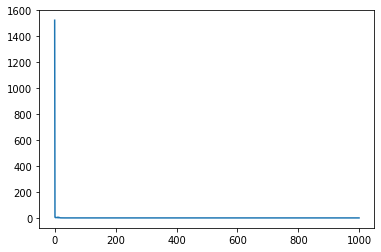

In [11]:
plt.plot(hist.history['loss'])

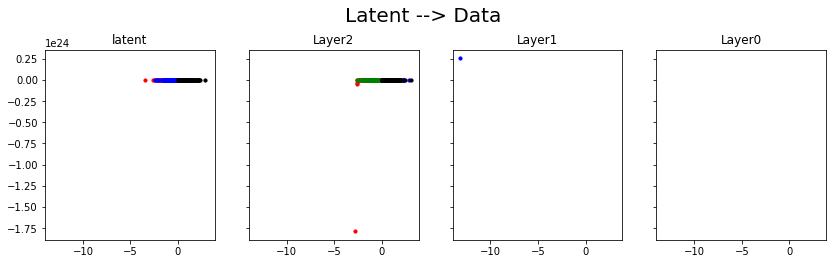

In [12]:
fig = visualize_from_latent(model, 500, title_txt='Latent --> Data', sharexy=True)

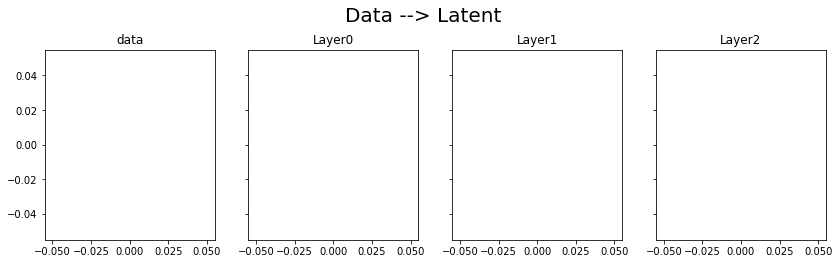

In [13]:
fig = visualize_from_data(model, 500, title_txt='Data --> Latent', sharexy=True)